# Module 3: Dimensionality reduction - Exercise

In this session you will compare both **feature selection** and **feature extraction** for dimensionality reduction, 
but we will still use **Naive Bayes** model.
We will apply these techniques to a real-world [HR Analytics dataset](https://www.kaggle.com/giripujar/hr-analytics).


The overall goal is to predict if an employee would leave the company.

##### NOTE

The goal is the get the best performance from the **Naive Bayes** model using feature reduction techniques. 
We can expect that a different model may be more suitable, 
however we want to only have a single moving part at a time so we will stay with Naive Bayes this week.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import numpy as np
import pandas as pd
np.random.seed(18937)

# Add code below this comment
# to import additional libraries
# and classes (Question #E101)
# ---------------------------
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.base import clone

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import scale

from scipy.stats import pearsonr

# Load dataset

Load dataset into a DataFrame and shuffle.

In [2]:
# Dataset location
DATASET = '/dsa/data/all_datasets/HR_analytics.csv'
assert os.path.exists(DATASET)

# Add code below this comment (Question #E102)
# ---------------------------

dataset = pd.read_csv(DATASET).sample(frac = 1).reset_index(drop=True)
dataset.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Print top 5 rows of the dataset.

In [3]:
# Add code below this comment (Question #E103)
# ---------------------------

dataset.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.85,0.90,5,202,3,0,0,0,IT,low
1,0.12,0.60,2,194,4,0,0,0,technical,medium
2,0.40,0.47,2,136,3,0,1,0,hr,medium
3,0.47,0.55,4,122,5,1,0,0,marketing,medium
4,0.89,0.65,5,195,6,0,1,0,support,low


## Processing

In the dataset, "sales" and "salary" are string columns,
which need some proccessing before we can start feature selection/extraction.

Play with following code and **add comments** to explain based on your understanding.
Feel free to drop questions on disscussion board if you encounter difficulties.

In [9]:
# Add line-by-line comments to explain following code (Question #E104)
# ===============================
from sklearn import preprocessing
encoder = preprocessing.LabelBinarizer()
salary_features = encoder.fit_transform(np.expand_dims(dataset.salary, 1))
for j, _class in enumerate(encoder.classes_):
    dataset.loc[:, 'salary_{}'.format(_class)] = salary_features[:, j]

dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,salary_high,salary_low,salary_medium
0,0.85,0.90,5,202,3,0,0,0,IT,low,0,1,0
1,0.12,0.60,2,194,4,0,0,0,technical,medium,0,0,1
2,0.40,0.47,2,136,3,0,1,0,hr,medium,0,0,1
3,0.47,0.55,4,122,5,1,0,0,marketing,medium,0,0,1
4,0.89,0.65,5,195,6,0,1,0,support,low,0,1,0


In [10]:
# help on fit_transform
help(encoder.fit_transform)

Help on method fit_transform in module sklearn.preprocessing._label:

fit_transform(y) method of sklearn.preprocessing._label.LabelBinarizer instance
    Fit label binarizer and transform multi-class labels to binary
    labels.
    
    The output of transform is sometimes referred to as
    the 1-of-K coding scheme.
    
    Parameters
    ----------
    y : {ndarray, sparse matrix} of shape (n_samples,) or                 (n_samples, n_classes)
        Target values. The 2-d matrix should only contain 0 and 1,
        represents multilabel classification. Sparse matrix can be
        CSR, CSC, COO, DOK, or LIL.
    
    Returns
    -------
    Y : {ndarray, sparse matrix} of shape (n_samples, n_classes)
        Shape will be (n_samples, 1) for binary problems. Sparse matrix
        will be of CSR format.



In [11]:
# help on expand_dims
help(np.expand_dims)

Help on function expand_dims in module numpy:

expand_dims(a, axis)
    Expand the shape of an array.
    
    Insert a new axis that will appear at the `axis` position in the expanded
    array shape.
    
    .. note:: Previous to NumPy 1.13.0, neither ``axis < -a.ndim - 1`` nor
       ``axis > a.ndim`` raised errors or put the new axis where documented.
       Those axis values are now deprecated and will raise an AxisError in the
       future.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int
        Position in the expanded axes where the new axis is placed.
    
    Returns
    -------
    res : ndarray
        View of `a` with the number of dimensions increased by one.
    
    See Also
    --------
    squeeze : The inverse operation, removing singleton dimensions
    reshape : Insert, remove, and combine dimensions, and resize existing ones
    doc.indexing, atleast_1d, atleast_2d, atleast_3d
    
    Examples
    --------
    >>> x = n

Now please write similar code for "sales" column like what we just did above. Feel free to drop questions on disscussion board if you need clarification.

In [16]:
# Add code below this comment (Question #E105)
# ---------------------------

encoder = preprocessing.LabelBinarizer()
sales_features = encoder.fit_transform(np.expand_dims(dataset.sales, 1))
for j, _class in enumerate(encoder.classes_):
    dataset.loc[:, 'sales_{}'.format(_class)] = sales_features[:, j]

dataset.head()


# ---------------------------


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.85,0.90,5,202,3,0,0,0,IT,low,...,1,0,0,0,0,0,0,0,0,0
1,0.12,0.60,2,194,4,0,0,0,technical,medium,...,0,0,0,0,0,0,0,0,0,1
2,0.40,0.47,2,136,3,0,1,0,hr,medium,...,0,0,0,1,0,0,0,0,0,0
3,0.47,0.55,4,122,5,1,0,0,marketing,medium,...,0,0,0,0,0,1,0,0,0,0
4,0.89,0.65,5,195,6,0,1,0,support,low,...,0,0,0,0,0,0,0,0,1,0


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
 10  salary_high            14999 non-null  int64  
 11  salary_low             14999 non-null  int64  
 12  salary_medium          14999 non-null  int64  
 13  sales_IT               14999 non-null  int64  
 14  sales_RandD            14999 non-null  int64  
 15  sa

Store feature columns (all columns except 'left', 'sales' and 'salary') to a new variable **X**. Here `left` is the class variable.

Store column(s) to be predicted into a new variable **y**.

In [36]:
list(dataset.columns)

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_montly_hours',
 'time_spend_company',
 'Work_accident',
 'left',
 'promotion_last_5years',
 'sales',
 'salary',
 'salary_high',
 'salary_low',
 'salary_medium',
 'sales_IT',
 'sales_RandD',
 'sales_accounting',
 'sales_hr',
 'sales_management',
 'sales_marketing',
 'sales_product_mng',
 'sales_sales',
 'sales_support',
 'sales_technical']

In [37]:
# Add code below this comment (Question #E106)
# ---------------------------

X = dataset.iloc[:, ~dataset.columns.isin(['left', 'sales', 'salary'])]
y = dataset.left

Create train/validate split (20% validation ratio) and use variable names: **X_train, X_test, y_train, y_test**.

In [41]:
# Add code below this comment (Question #E107)
# ---------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Feature selection and evaluation

In this section you could make use of any method so far introduced or provided by sklearn for **feature selection**.

Steps:
1. Initialize a feature selector
2. Fit feature selector on training set
3. Print indices of features selected, the "support".
4. Train a Gaussian Naive Bayes model on selected features from training set.
5. Evaluate the model by measuring its accuracy on the test set.

Please **briefly answer the 2 questions** at the end of this section; use evidence printed from your code as appropiate to support your answer. 

It is not required but if you are comparing different feature selection methods,
please add new notebook cells for each method.

In [49]:
# Add code below this comment (Question #E108)
# ---------------------------

selector = SelectKBest(chi2, k=4)


In [50]:
selector.fit(X_train, y_train)
selector.scores_

array([1.81535117e+02, 4.48445122e-02, 3.72329462e+00, 7.94896891e+02,
       1.56525975e+02, 2.51281160e+02, 4.78547228e+01, 1.61801609e+02,
       1.21291796e+02, 3.75952950e+01, 6.37107974e-01, 2.80140334e+01,
       4.04950887e+00, 1.07948130e+01, 2.27176338e+01, 6.14596997e-02,
       2.89620782e+00, 4.43749081e-02, 1.58555395e+00, 5.10618897e+00])

In [51]:
selector.get_support(True)

array([0, 3, 5, 7])

In [52]:
[dataset.columns[i] for i in selector.get_support(True)]

['satisfaction_level',
 'average_montly_hours',
 'Work_accident',
 'promotion_last_5years']

In [53]:
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

In [54]:
model = GaussianNB()
model.fit(X_train_selected, y_train)
model.score(X_test_selected, y_test)

0.7686666666666667

In [55]:
model = GaussianNB()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6456666666666667

How many number of features did you finally choose? Why?

# Feature extraction

In this section you could use **Principle Component Analysis** or **Factor Analysis** for feature extraction.

Steps:
1. Initialize either PCA or FactorAnalysis
2. Fit feature extractor on training set.
4. Train a Gaussian Naive Bayes model on selected features from training set.
5. Evaluate the model by measuring its accuracy on the test set.

In [44]:
# Add code below this comment (Question #E110)
# ---------------------------

pca = PCA(n_components=5)
pca.fit(X)

PCA(n_components=5)

In [45]:
print('PCA', pca.explained_variance_ratio_)

PCA [9.97999534e-01 8.69342838e-04 4.73823077e-04 1.82844960e-04
 9.48675248e-05]


In [46]:
X_PCA = pca.transform(X)
print([pearsonr(X_PCA[:,i], y)[0] for i in range(X_PCA.shape[1])])

[0.07130068257202477, 0.12797219577146957, 0.052926853266034586, -0.11594648308196258, -0.0015508363670436775]


In [47]:
X_centered = scale(X_PCA, with_std = False)
y_centered = scale(y.astype(float), with_std = False)
cosine = lambda a,b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
cosine = lambda a,b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
print([cosine(X_centered[:, j], y_centered) for j in range(X_PCA.shape[1])])

[0.0713006825720248, 0.12797219577146954, 0.052926853266034586, -0.11594648308196254, -0.0015508363670436827]


Create a scree plot of **explained variance ratio** for extracted features.

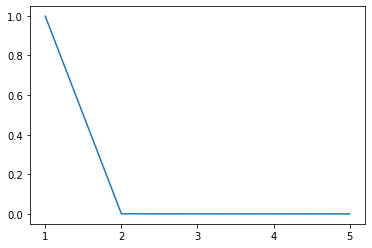

In [48]:
# Add code below this comment (Question #E111)
# ---------------------------
x_ticks = np.arange(len(pca.components_))+1
plt.xticks(x_ticks)

plt.plot(x_ticks, pca.explained_variance_ratio_)


Do you think this feature extraction method performed satisfactorily?
How does it compare to feature selection methods in terms of effectiveness?

How would you explain the features you have extracted to somebody without a data science background if you were to recommend this method?
(short answer)

# Save your notebook!  Then `File > Close and Halt`